In [23]:
import subprocess
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates


import subprocess
import json

def fetch_data_from_js():
    try:
        result = subprocess.run(
            ['node', 'fetchAccountingData.js'], 
            capture_output=True, 
            text=True,  
            check=True
        )
        print(result)

        raw_output = result.stdout.strip()
        error_output = result.stderr.strip()  

        print("Raw Output:", raw_output)
        if error_output:
            print("Error Output:", error_output)

        if not raw_output:
            print("Warning: No output received from Node.js script.")
            return None  

        return json.loads(raw_output)

    except subprocess.CalledProcessError as e:
        print(f"Subprocess Error: {e}")
        print(f"Error Output: {e.stderr}")
        return None  
    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {e}")
        print("Raw output was not valid JSON:", raw_output)
        return None  



def balance_briefing(data_accounting_balance_sheets, output_file=None):
    output_data = []

    for balance_sheet in data_accounting_balance_sheets:
        date = balance_sheet.get("date")
        report_json = balance_sheet.get("report_json")

        assets = report_json.get("assets")[0]
        assets_subitems = assets.get("sub_items", [])
        asset_sub = [
            {"name": asset_item.get("name"), "value": asset_item.get("value")}
            for asset_item in assets_subitems
        ]

        liabilities = report_json.get("liabilities")[0]
        liabilities_subitems = liabilities.get("sub_items", [])
        liability_sub = [
            {"name": liability_item.get("name"), "value": liability_item.get("value")}
            for liability_item in liabilities_subitems
        ]

        equity = report_json.get("equity")[0]
        equity_subitems = equity.get("sub_items", [])
        equity_sub = [
            {"name": equity_item.get("name"), "value": equity_item.get("value")}
            for equity_item in equity_subitems
        ]

        net_income = next(
            (equity_item.get("value") for equity_item in equity_subitems if equity_item.get("name") == "Net Income"),
            None
        )

        total_assets = assets.get("value") or 1
        total_liabilities = liabilities.get("value") or 1
        total_equity = equity.get("value") or 1
        net_income = net_income or 0

        # Calculate financial ratios
        current_ratio = total_assets / total_liabilities
        debt_to_equity_ratio = total_liabilities / total_equity
        return_on_equity = net_income / total_equity
        equity_multiplier = total_assets / total_equity
        debt_ratio = total_liabilities / total_assets
        net_profit_margin = net_income / total_assets

        balance_sheet_output = {
            "date": date,
            "total_asset": total_assets,
            "asset_breakdown": asset_sub,
            "total_liability": total_liabilities,
            "liability_breakdown": liability_sub,
            "total_equity": total_equity,
            "equity_breakdown": equity_sub,
            "net_income": net_income,
            "ratios": {
                "current_ratio": current_ratio,
                "debt_to_equity_ratio": debt_to_equity_ratio,
                "return_on_equity": return_on_equity,
                "equity_multiplier": equity_multiplier,
                "debt_ratio": debt_ratio,
                "net_profit_margin": net_profit_margin,
            },
        }

        output_data.append(balance_sheet_output)

    # Optional: Write output to a file if specified
    if output_file:
        import json
        with open(output_file, "w") as f:
            json.dump(output_data, f, indent=4)
        print(f"Balance sheet data has been written to {output_file}")

    return output_data

def plot_financial_briefing(output_data):
    """
    Plots financial ratios and major financial statistics from balance sheet data.

    Parameters:
    - output_data: List of dictionaries containing balance sheet data and ratios.
      Each dictionary should include:
        - 'date'
        - 'total_asset'
        - 'total_liability'
        - 'total_equity'
        - 'net_income'
        - 'ratios': Dictionary containing financial ratios
    """
    # Extract data for plotting
    dates = [datetime.fromisoformat(item['date']) for item in output_data]
    total_assets = [item['total_asset'] for item in output_data]
    total_liabilities = [item['total_liability'] for item in output_data]
    total_equities = [item['total_equity'] for item in output_data]
    net_incomes = [item['net_income'] for item in output_data]

    current_ratios = [item['ratios']['current_ratio'] for item in output_data]
    debt_to_equity_ratios = [item['ratios']['debt_to_equity_ratio'] for item in output_data]
    return_on_equities = [item['ratios']['return_on_equity'] for item in output_data]
    equity_multipliers = [item['ratios']['equity_multiplier'] for item in output_data]
    debt_ratios = [item['ratios']['debt_ratio'] for item in output_data]
    net_profit_margins = [item['ratios']['net_profit_margin'] for item in output_data]

    # Plotting
    fig = plt.figure(figsize=(18, 22))
    gs = gridspec.GridSpec(4, 2, height_ratios=[1.5, 1, 1, 1])

    # Major Financial Statistics Plot
    ax_major_stats = fig.add_subplot(gs[0, :])
    ax_major_stats.plot(dates, total_assets, label='Total Assets', marker='o')
    ax_major_stats.plot(dates, total_liabilities, label='Total Liabilities', marker='o')
    ax_major_stats.plot(dates, total_equities, label='Total Equities', marker='o')
    ax_major_stats.plot(dates, net_incomes, label='Net Income', marker='o')
    ax_major_stats.set_title('Major Financial Statistics')
    ax_major_stats.set_xlabel('Date')
    ax_major_stats.set_ylabel('Value (USD)')
    ax_major_stats.legend()
    ax_major_stats.grid(True)

    # Adjust x-axis ticks for clarity
    ax_major_stats.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax_major_stats.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate(rotation=45)

    # Individual Ratio Plots
    axs = [
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, 0]),
        fig.add_subplot(gs[2, 1]),
        fig.add_subplot(gs[3, 0]),
        fig.add_subplot(gs[3, 1]),
    ]

    ratio_titles = [
        'Current Ratio',
        'Debt to Equity Ratio',
        'Return on Equity',
        'Equity Multiplier',
        'Debt Ratio',
        'Net Profit Margin',
    ]
    ratio_data = [
        current_ratios,
        debt_to_equity_ratios,
        return_on_equities,
        equity_multipliers,
        debt_ratios,
        net_profit_margins,
    ]

    for ax, title, data in zip(axs, ratio_titles, ratio_data):
        ax.plot(dates, data, marker='o')
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel('Ratio')
        ax.grid(True)

        # Adjust x-axis ticks for clarity
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Automatically adjust layout and add space between plots
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing
    fig.autofmt_xdate(rotation=45)  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

def get_terminal_subitems(items):
    terminal_items = []
    for item in items:
        subitems = item.get("sub_items", [])
        if subitems:
            terminal_items.extend(get_terminal_subitems(subitems))
        else:
            terminal_items.append(item)
    return terminal_items


In [2]:
import subprocess
import json

def get_all_tables():
    try:
        result = subprocess.run(
            ['node', 'get_all_tables.js'],
            capture_output=True,
            text=True,
            check=True
        )

        raw_output = result.stdout.strip()
        data = json.loads(raw_output)

        return data

    except subprocess.CalledProcessError as e:
        print("Error running the JavaScript file:", e)
        print("Stderr:", e.stderr)
        return None
    except json.JSONDecodeError as e:
        print("Error parsing JSON:", e)
        print("Raw JSON Response:", result.stdout)
        return None

all_data_tables = get_all_tables()

if all_data_tables:
    print("Table Names:", all_data_tables)
else:
    print("Failed to retrieve table names.")


Table Names: ['accounting_invoices', 'accounting_invoice_applied_credit_notes', 'accounting_expense_lines', 'accounting_income_statements', 'accounting_company_info', 'accounting_invoice_line_items', 'accounting_journal_entries', 'accounting_balance_sheets', 'integration_connections', 'sources', 'ref_integration_platform', 'organization_user', 'accounting_transactions', 'accounting_accounts', 'accounting_expenses', 'accounting_cash_flow_statements', 'accounting_transaction_line_items', 'accounting_invoice_applied_vendor_credits', 'accounting_journal_entry_lines', 'organization']


CompletedProcess(args=['node', 'fetchAccountingData.js'], returncode=0, stdout='{"accounting_accounts":[{"id":"83c8f241-2433-4d8b-863a-e5d5c198b5cd","remote_id":"88","created_at":"2025-01-14T03:24:56.195333+00:00","modified_at":"2025-01-14T03:24:56.195338+00:00","name":"Vehicles (deleted)","description":"Vehicles the business owns","classification":"ASSET","type":"Fixed Asset","account_type":"FIXED_ASSET","status":"INACTIVE","current_balance":0,"currency":"USD","account_number":null,"parent_account":null,"company":null,"remote_was_deleted":false,"org_id":"04947b7b-fd9a-43e7-84e9-50089fd29cba","source_id":"1a5c296f-7d80-41cb-bba2-cb4724745e81"},{"id":"a07be7f2-6b56-49ee-b7ab-5a46783b11da","remote_id":"87","created_at":"2025-01-14T03:24:56.194891+00:00","modified_at":"2025-01-14T03:24:56.194896+00:00","name":"Vehicle expenses (deleted)","description":"Costs for the use of vehicles","classification":"EXPENSE","type":"Other Expense","account_type":"OTHER_EXPENSE","status":"INACTIVE","curre

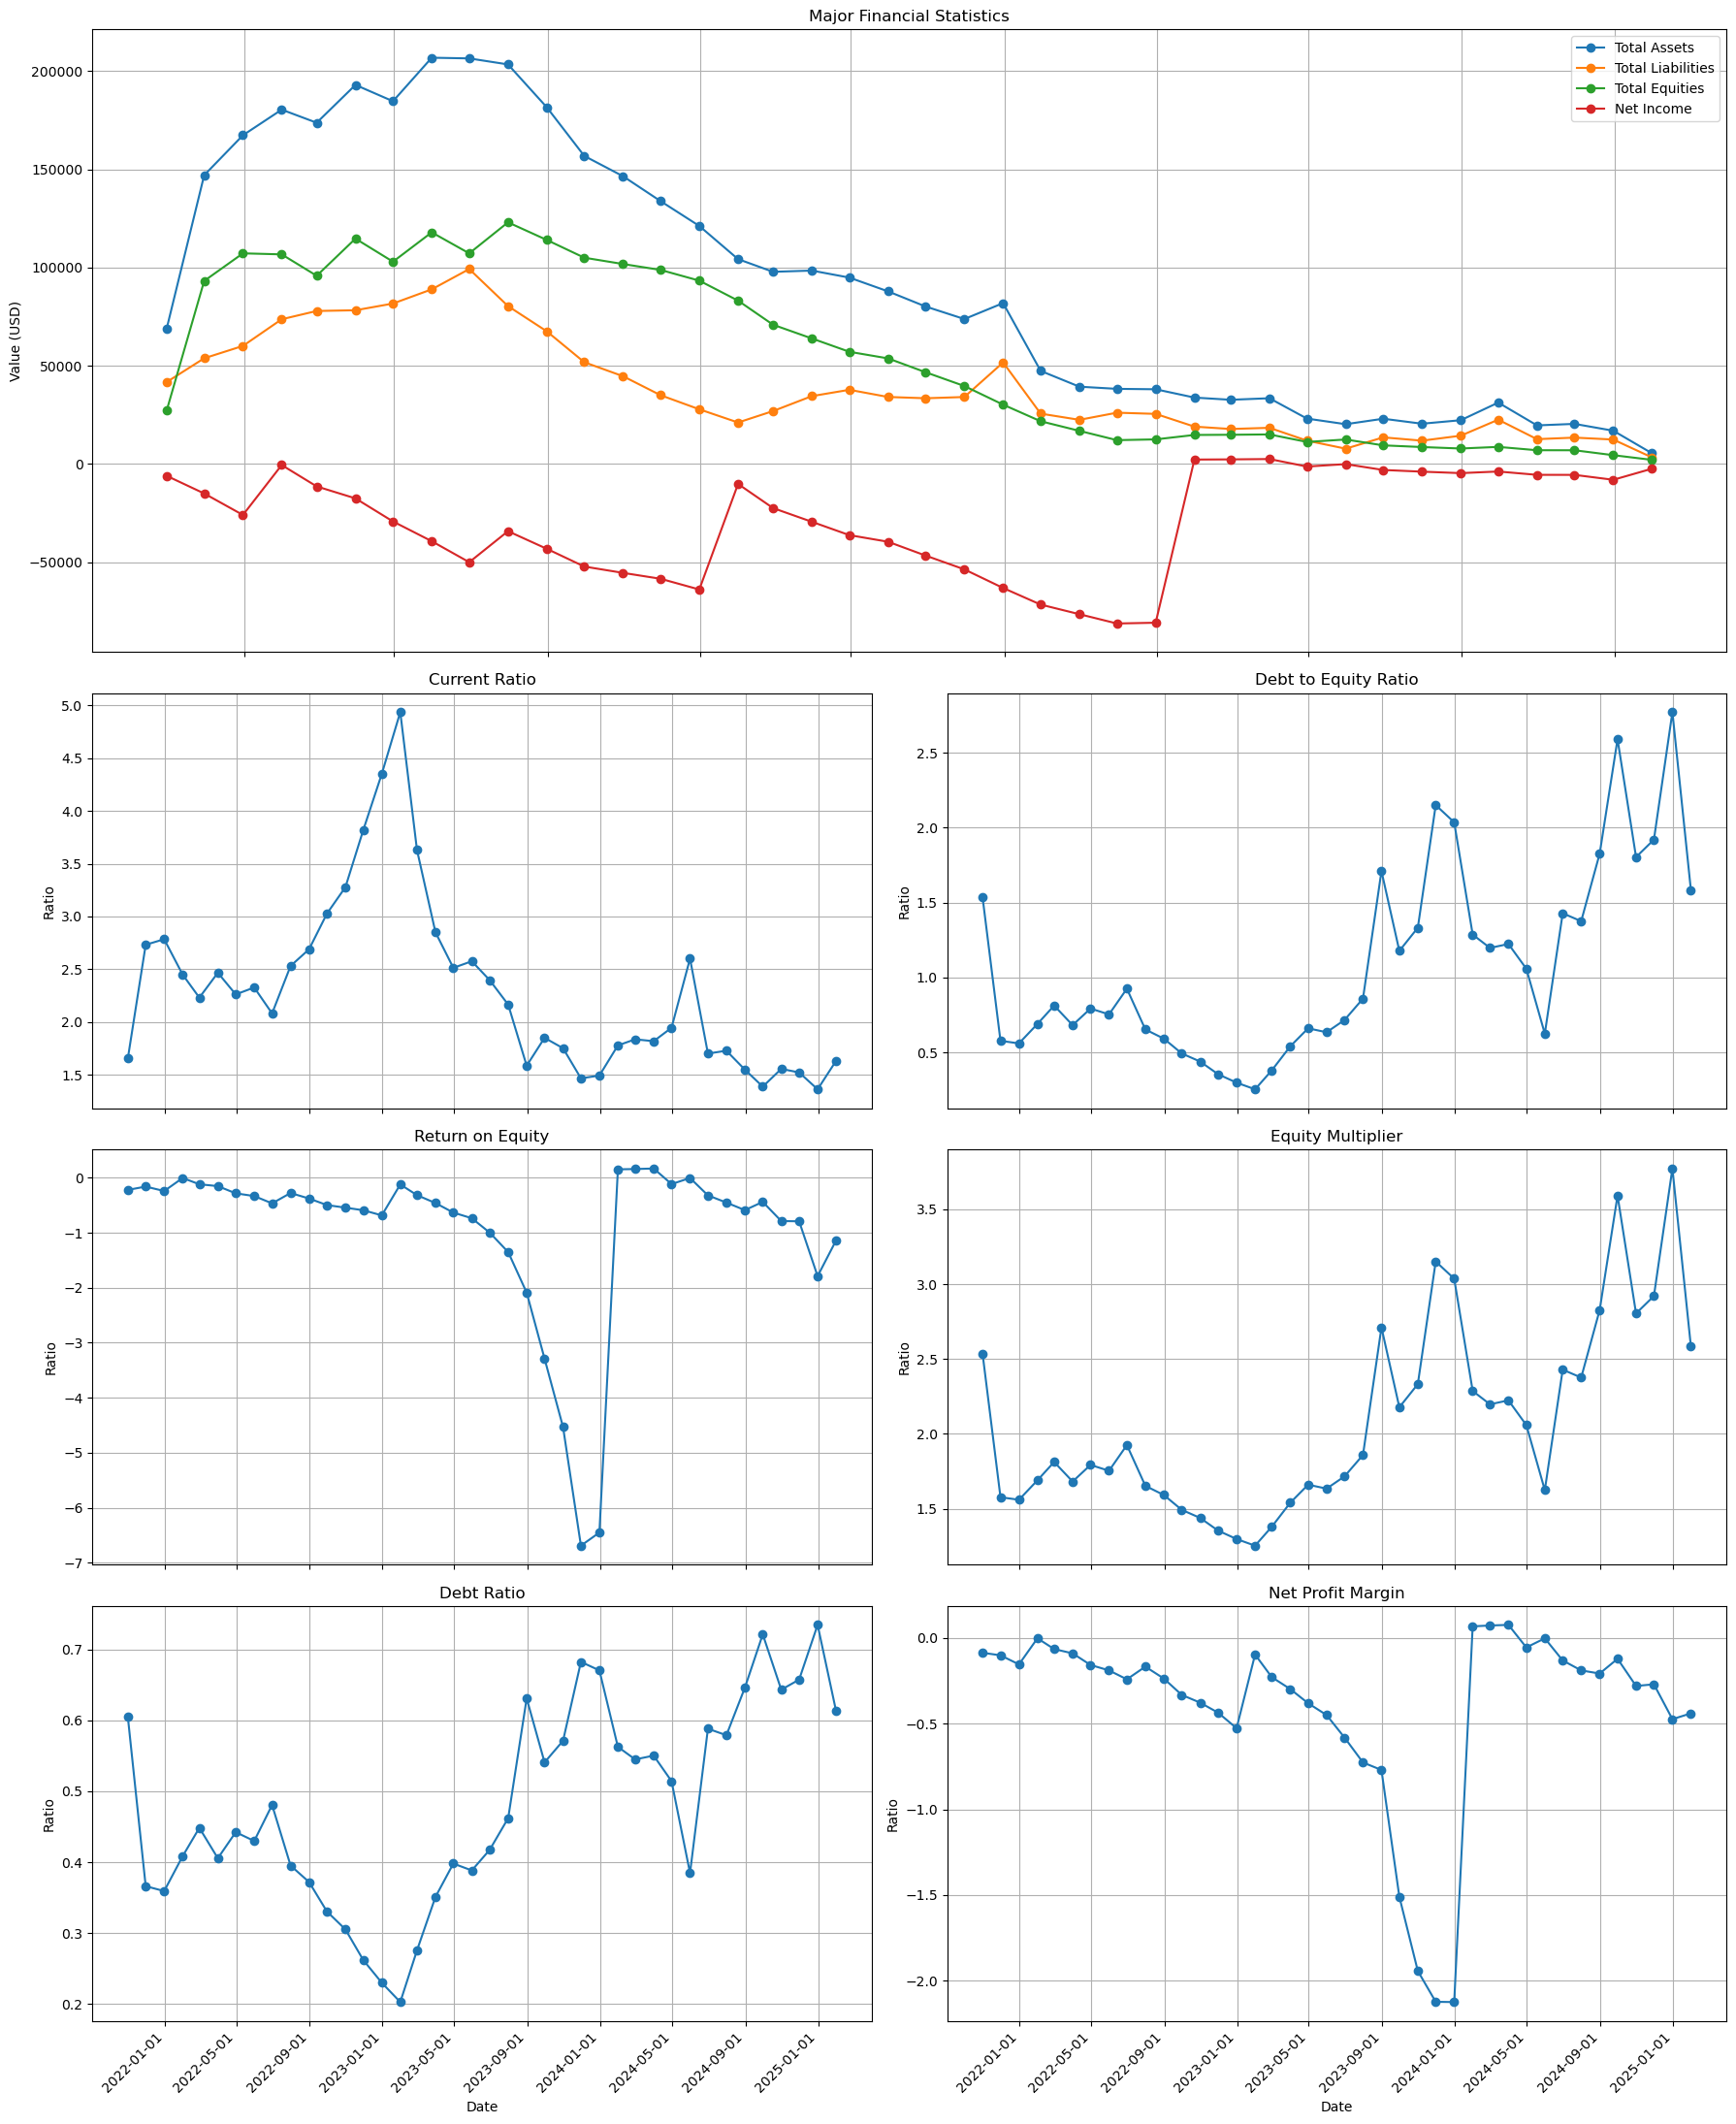

In [24]:
data = fetch_data_from_js()
print("Data:", data)
if data:
    data_accounting_accounts = data.get("accounting_accounts")
    print("Accounting Accounts:", data_accounting_accounts)
    data_accounting_balance_sheets = data.get("accounting_balance_sheets")

#output_file = "balance_sheet_output.json"
#balance_sheets = balance_briefing(data_accounting_balance_sheets, output_file)

balance_sheets = balance_briefing(data_accounting_balance_sheets)

try:
    balance_sheets.sort(key=lambda x: datetime.fromisoformat(x['date']))
except KeyError:
    print("Error: Missing 'date' field in one or more records.")
    balance_sheets = [] 
except ValueError as e:
    print(f"Error: Invalid date format in one or more records. {e}")
    balance_sheets = []  

if balance_sheets:
    dates = [sheet['date'] for sheet in balance_sheets]
    plot_financial_briefing(balance_sheets)
else:
    print("No valid balance sheet data to process.")


In [5]:
#Financial summary: given a date, return the financial summary of the nearest date of the balance sheet of the company


def financial_summary(balance_sheets, target_date):
    nearest_date = None

    target_date = datetime.fromisoformat(target_date).replace(tzinfo=None)
    dates = [datetime.fromisoformat(sheet['date']).replace(tzinfo=None) for sheet in balance_sheets]
    
    if target_date in dates:
        nearest_date = target_date
    else:
        nearest_date = min(dates, key=lambda x: abs(x - target_date))
    nearest_index = dates.index(nearest_date)
    nearest_sheet = balance_sheets[nearest_index]

    return nearest_sheet

target_date = "2021-06-30"
summary = financial_summary(balance_sheets, target_date)

prompt = f"""Financial data and calculated ratios:{summary}. Using the provided balance sheet data for the specified date, {target_date}, generate a concise financial analysis report evaluating the company's financial health. The report should be structured into the following six sections: 
1. Financial Summary: Provide an overview of the key financial figures, including total assets, liabilities, equity, and net income, highlighting any significant observations.
2. Breakdown of Financial Components: Analyze and describe the composition of assets, liabilities, and equity, noting any dominant or missing components.
3. Key Financial Ratios Interpretation: Evaluate the company's financial health by interpreting relevant ratios (e.g., current ratio, debt-to-equity ratio, return on equity, equity multiplier, debt ratio, and net profit margin) in the context of standard benchmarks.
4. Key Findings: Highlight the most critical takeaways from the data, such as liquidity, solvency, profitability, or significant trends.
5. Key Insights: Summarize actionable insights that can be drawn from the analysis, focusing on areas of strength, risks, or opportunities.
6. Recommendations: Provide practical recommendations for improving financial performance, mitigating risks, or leveraging opportunities.
Ensure that the analysis is clear, precise, and easy to understand, using the data provided to support conclusions where applicable."""

import openai

from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"), 
)

chat_completion = client.chat.completions.create(
    messages=[
        {"role": "system", "content": "You are a helpful professional financial analyst."},
        {
            "role": "user",
            "content": f"{prompt}",
        }
    ],
    model="gpt-4o",
)

# Print the response
print(chat_completion.choices[0].message.content)


In [39]:
import json

cleaned = []
for balance_sheet in data_accounting_balance_sheets:
    sheet = []
    sheet.append({"date": balance_sheet.get("date")})

    # Process assets
    asset = []
    assets = balance_sheet.get("report_json", {}).get("assets", [])
    terminal_items = get_terminal_subitems(assets)
    for item in terminal_items:
        asset.append({
            "name": item.get("name"),
            "value": item.get("value"),
            "remote_id": item.get("remote_id")
        })

    # Process equities
    equity = []
    equities = balance_sheet.get("report_json", {}).get("equity", [])
    terminal_items = get_terminal_subitems(equities)
    for item in terminal_items:
        equity.append({
            "name": item.get("name"),
            "value": item.get("value"),
            "remote_id": item.get("remote_id")
        })

    # Process liabilities
    liability = []
    liabilities = balance_sheet.get("report_json", {}).get("liabilities", [])
    terminal_items = get_terminal_subitems(liabilities)
    for item in terminal_items:
        liability.append({
            "name": item.get("name"),
            "value": item.get("value"),
            "remote_id": item.get("remote_id")
        })

    # Append processed data
    sheet.append({"asset": asset})
    sheet.append({"equity": equity})
    sheet.append({"liability": liability})
    cleaned.append({"balance_sheet": sheet})

print(cleaned[0])



output_file = "cleaned_balance_sheets.json"
with open(output_file, "w") as f:
    json.dump(cleaned, f, indent=4)

print(f"Data written to {output_file}")



{'balance_sheet': [{'date': '2025-01-31T00:00:00+00:00'}, {'asset': [{'name': 'Security deposits', 'value': 0, 'remote_id': '74'}, {'name': 'Accounts receivable', 'value': 0, 'remote_id': '7'}, {'name': 'QB Default Funds', 'value': 0, 'remote_id': '60'}, {'name': 'Prepaid expenses', 'value': 299, 'remote_id': '65'}, {'name': 'Undeposited Funds', 'value': -1984.29, 'remote_id': '155'}, {'name': 'Sentient OPEX 8399', 'value': 0, 'remote_id': '149'}, {'name': 'Sentient Inc 7536', 'value': 7113.78, 'remote_id': '180'}]}, {'equity': [{'name': 'Opening balance equity', 'value': 0, 'remote_id': '58'}, {'name': 'Common stock', 'value': 8227.76, 'remote_id': '20'}, {'name': 'SAFE', 'value': 175000, 'remote_id': '158'}, {'name': 'Retained Earnings', 'value': -178735.16, 'remote_id': '4'}, {'name': 'Net Income', 'value': -2392.46, 'remote_id': None}]}, {'liability': [{'name': 'Chase 7770', 'value': 2042.03, 'remote_id': '150'}, {'name': 'Best Buy', 'value': 707.22, 'remote_id': '154'}, {'name': '